# Setup

In [1]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    read_data, read_model, # Data Ingestion
    filter_df, check_target_dependency, # EDA
    calculate_psi, run_chi_square_tests, # Validation
    train_lgbm, # Model Training
    percentile, clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    calc_intraday_gradient
)

In [2]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time
import catboost
from catboost import CatBoostRegressor, Pool

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%load_ext autoreload
%autoreload

In [4]:
DATA_DIR = '../data/'

In [5]:
joblib.__version__

'1.3.2'

# Tree-Based Model Training

In [6]:
%%time
# Read the final dataframe from feature engineering notebook
train_path = f"{DATA_DIR}/optiver-train-data/train_by_batch_gen_v6.parquet"
train = read_data(train_path)
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 1.3 GB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 48.91it/s]

After downcast: 	RAM used: 0.6 GB
CPU times: user 8.87 s, sys: 18.4 s, total: 27.3 s
Wall time: 16.3 s


In [7]:
# Set the target columns to avoid target leakage into X_train
target_column_list = get_cols(train, "target", excludes=["normalized", "daily", "grad"])
target_column_list

['target', 'clipped_target', 'is_positive_target', 'is_mild_target']

In [8]:
# # Get the list of features to avoid based on previous experiments / analysis
# corr_but_noob_features = joblib.load("../features_summary/corr_but_noob_features.pkl")
# print(corr_but_noob_features[:10])

In [9]:
# lgbm_model = read_model(f'{DATA_DIR}/optiver-lgbm-models/lgbm_model7.txt')
# imp_df = plot_feature_importance(lgbm_model.feature_name(), lgbm_model.feature_importance(), return_df=True)
# low_imp_features = imp_df.loc[imp_df["feature_importance"] < 140, "feature"].tolist()

In [10]:
def get_final_features(df, noob_features=[], target_columns=target_column_list, meta_columns=META_COLUMNS[:2]):
    return list_diff(df.columns, noob_features + target_columns + meta_columns)

In [11]:
train.shape

(5237760, 392)

## LGBM 

In [12]:
LGBM_MODEL_VERSION = 11
lgbm_val_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.txt'
lgbm_val_data_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.csv'
lgbm_final_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}.txt'

In [13]:
# val_model = read_model(lgbm_final_model_path)

### Optuna Tuning (Ignore this first)

In [14]:
imp_df = read_data("../imp_df.parquet")
best_features = joblib.load("../features.pkl")

In [15]:
imp_df = imp_df.loc[imp_df["feature"].isin(best_features)].reset_index(drop=True)

In [16]:
imp_df.shape

(562, 3)

In [17]:
# These are be the static hyperparams for our ML problem + your machine specifications
lgbm_general_settings = dict(
    objective='mae', 
    histogram_pool_size=256, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=512, 
    n_jobs=-1, 
    verbose=-1
)

In [18]:
def objective(trial):
    cprint(f"{get_time_now()} Suggesting hyparameters for this trial...", color="green")
    lgbm_trial_params = dict(
        boosting_type="gbdt", # trial.suggest_categorical("boosting_type", []),
        learning_rate=trial.suggest_float("learning_rate", 0.005, 0.0125), # 0.018052307589575444, 
        max_depth=trial.suggest_categorical("max_depth", [11, 12, -1]), 
        n_estimators=4000, # trial.suggest_int("n_estimators", 2000, 3000, step=100),
        num_leaves=trial.suggest_int("num_leaves", 250, 450, step=50), 
        reg_alpha=trial.suggest_float("reg_alpha", 0.03, 0.1, log=True), # 0.02216069565875271, 
        reg_lambda=trial.suggest_float("reg_lambda", 2, 10, log=True), # 0.01223572246957101,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.45, 0.7),
        subsample=trial.suggest_float("subsample", 0.7, 0.9),
        min_child_samples=trial.suggest_int("min_child_samples", 2, 16, step=2),
        min_split_gain=0.25, # trial.suggest_float("min_split_gain", 0.2, 0.3),
        verbose=-1
    )
    final_lgbm_params = lgbm_general_settings | lgbm_trial_params
    print(final_lgbm_params)
    
    num_features = 500 # trial.suggest_int("num_features", 500, 50, step=10)
    feature_list = imp_df.iloc[:num_features]["feature"].tolist()
    
    val_model, valid_pred, best_score = train_lgbm(
        data=train, train_start_date=1, train_end_date=420, val_start_date=421, 
        es=True, get_val_pred=True, feature_list=feature_list, lgbm_params=final_lgbm_params
    )
    return best_score

In [19]:
# joblib.dump(study, "../study.pkl")

In [20]:
# study3 = optuna.create_study(direction="minimize")
# study3.optimize(objective, n_trials=25)

In [21]:
# joblib.dump(study3, "../tuning_result/lgbm_optuna3.pkl")

In [22]:
# plot_scatterplot(study_df, x_col="temp", y_col="value", ticksize=17)

In [23]:
# study_df = study3.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"]
# # study_df.to_csv(f"../optuna_trials.csv", index=False)
# fig, ax = plt.subplots(3, 3, figsize=(21, 16))
# ax = ax.ravel()
# for i, col in enumerate(get_cols(study_df, "params")):
#     sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"], ax=ax[i])
# plt.suptitle("Optuna Tuning Result", y=0.9)
# plt.savefig("../tuning_result/lgbm_optuna_result2.png")
# plt.show()

### First Training for Validation 

In [24]:
lgbm_study = joblib.load("../tuning_result/lgbm_optuna2.pkl")

In [25]:
# These are be the static hyperparams for our ML problem + your machine specifications
lgbm_general_settings = dict(
    n_estimators=2300, 
    min_split_gain=0.25, 
    objective='mae', 
    histogram_pool_size=128, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=400, 
    n_jobs=-1, 
    verbose=-1
)

In [26]:
lgbm_params = lgbm_study.best_params
lgbm_params["learning_rate"] = 0.01

In [27]:
# # We manually set here, but this can be str8 away came from optuna best hyper-params
# lgbm_params = {
#     'boosting_type': 'gbdt', 
#     'learning_rate': 0.0165,
#     'max_depth': 12,
#     'n_estimators': 1000,
#     'num_leaves': 420, 
#     'reg_alpha': 0.3,
#     'reg_lambda': 1,
#     'colsample_bytree': 0.65,
#     'subsample': 0.7,
#     'min_child_samples': 16,
#     'min_split_gain': 0.2,  
#     'min_child_weight': 0.001, 
#     "device": "cpu"
# }

In [28]:
# Final hyper-params set
full_lgbm_params = lgbm_general_settings | lgbm_params
print(full_lgbm_params)

{'n_estimators': 2300, 'min_split_gain': 0.25, 'objective': 'mae', 'histogram_pool_size': 128, 'force_col_wise': True, 'random_state': 1020, 'max_bin': 400, 'n_jobs': -1, 'verbose': -1, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 400, 'reg_alpha': 0.03509689562307177, 'reg_lambda': 5.183354801921556, 'colsample_bytree': 0.6949832282432649, 'subsample': 0.748072282616451, 'min_child_samples': 10}


In [29]:
feature_list = list_diff(train.columns.tolist(), META_COLUMNS[:2] + target_column_list + imp_df.iloc[-50:]["feature"].tolist() + get_cols(train, endswith="flag"))
# feature_list = imp_df.loc[:300, "feature"].tolist()
len(feature_list)

373

In [30]:
gc.collect()

110

In [33]:
# %%time
# val_model, valid_pred, best_score = train_lgbm(
#     data=train, train_start_date=10, train_end_date=420, val_start_date=421, 
#     es=True, get_val_pred=True, feature_list=feature_list, lgbm_params=full_lgbm_params
# )

22:13:08 Preparing Dataset...
22:14:04 Training...
Training until validation scores don't improve for 230 rounds
[50]	training's l1: 6.42276	training's mae: 6.42276	valid_0's l1: 5.75739	valid_0's mae: 5.75739
[100]	training's l1: 6.37768	training's mae: 6.37768	valid_0's l1: 5.7315	valid_0's mae: 5.7315
[150]	training's l1: 6.35013	training's mae: 6.35013	valid_0's l1: 5.71793	valid_0's mae: 5.71793
[200]	training's l1: 6.32999	training's mae: 6.32999	valid_0's l1: 5.70957	valid_0's mae: 5.70957
[250]	training's l1: 6.31242	training's mae: 6.31242	valid_0's l1: 5.70306	valid_0's mae: 5.70306
[300]	training's l1: 6.29699	training's mae: 6.29699	valid_0's l1: 5.69838	valid_0's mae: 5.69838
[350]	training's l1: 6.28317	training's mae: 6.28317	valid_0's l1: 5.69455	valid_0's mae: 5.69455
[400]	training's l1: 6.27032	training's mae: 6.27032	valid_0's l1: 5.69207	valid_0's mae: 5.69207
[450]	training's l1: 6.25746	training's mae: 6.25746	valid_0's l1: 5.68978	valid_0's mae: 5.68978
[500]	tr

In [36]:
lgbm_val_model_path, lgbm_val_data_path

('../data//optiver-lgbm-models/lgbm_model11_val.txt',
 '../data//optiver-lgbm-models/lgbm_model11_val.csv')

In [35]:
val_model.save_model(lgbm_val_model_path)

In [37]:
valid_pred.to_csv(lgbm_val_data_path, index=False)

In [29]:
val_model = read_model(lgbm_val_model_path)

### Train for Submission (Final Model) 

In [30]:
# Use back the same features, so that the validation score holds
best_new_features = feature_list # best_features

In [31]:
# Can update the number of trees if the early stopping get hit during validation, because we have no holdout set for early stopping when we train using Date ID 1 - 480
best_lgbm_params = full_lgbm_params
best_lgbm_params["n_estimators"] = 2500 # int(val_model.best_iteration * 1.1)
best_lgbm_params

{'n_estimators': 2500,
 'min_split_gain': 0.25,
 'objective': 'mae',
 'histogram_pool_size': 128,
 'force_col_wise': True,
 'random_state': 1020,
 'max_bin': 400,
 'n_jobs': -1,
 'verbose': -1,
 'learning_rate': 0.01,
 'max_depth': 11,
 'num_leaves': 400,
 'reg_alpha': 0.03509689562307177,
 'reg_lambda': 5.183354801921556,
 'colsample_bytree': 0.6949832282432649,
 'subsample': 0.748072282616451,
 'min_child_samples': 10}

In [35]:
train = train.loc[:, META_COLUMNS + best_new_features + target_column_list]

In [36]:
gc.collect()

888

In [ ]:
%%time
lgbm_model, _, _ = train_lgbm(
    data=train, train_start_date=10, train_end_date=480, val_start_date=478, val_end_date=480, 
    es=False, get_val_pred=False, feature_list=best_new_features, lgbm_params=best_lgbm_params
)

23:50:39 Preparing Dataset...
23:51:38 Training...


In [ ]:
final_model_path

In [ ]:
%%time
lgbm_model.save_model(final_model_path)

In [ ]:
gc.collect()

## CatBoost

In [16]:
CAT_MODEL_VERSION = "3"
cat_val_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.cbm"
cat_val_data_path = f'{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.csv'
cat_final_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}.cbm"

### Optuna Tuning

In [23]:
feature_list = imp_df.iloc[:500]["feature"].tolist()

In [24]:
%%time
tr = filter_df(train, date_id=(0, 420), seconds=(0, 540)).reset_index(drop=True)
va = filter_df(train, date_id=(421, 480), seconds=(0, 540)).reset_index(drop=True)

X_tr = tr.loc[:, feature_list]
y_tr = tr["target"]
X_va = va.loc[:, feature_list]
y_va = va["target"]

CPU times: user 3.49 s, sys: 18.6 s, total: 22.1 s
Wall time: 1min 13s


In [37]:
def objective(trial):
    # Set the hyperparameter range to tune
    params = dict(
        iterations=2000, # trial.suggest_int("iterations", 2000, 2500, step=250),
        learning_rate=0.01, # trial.suggest_float("learning_rate", 0.003, 0.03, log=True),
        depth=trial.suggest_int("depth", 10, 12, step=1),
        subsample=trial.suggest_float("subsample", 0.8, 0.95),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.7, 0.9),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 2, 10, step=4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1, 4),
        border_count=trial.suggest_int("border_count", 60, 100, step=20),
        nan_mode="Max", # trial.suggest_categorical("nan_mode", ["Min", "Max"]),
        sampling_frequency="PerTree", # trial.suggest_categorical("sampling_frequency", ["PerTree", "PerTreeLevel"]),
        langevin=True, # trial.suggest_categorical("langevin", [True, False]),
        mvs_reg=trial.suggest_float("mvs_reg", 0.1, 3, log=True),
        loss_function="MAE", 
        grow_policy="SymmetricTree",
        bootstrap_type="MVS", 
        od_type="Iter",
        od_wait=150,
        metric_period=25,
        random_state=999, 
        verbose=0,
    )
    is_clip_target = trial.suggest_categorical("clip_target", [True, False])
    if is_clip_target:
        y_tr = tr["clipped_target"]
    else:
        y_tr = tr["target"]
    cprint(f"{get_time_now()}, Hyperparams: {params}", color="green")
    model = CatBoostRegressor(**params)
    model.fit(
        X_tr, 
        y_tr,
        eval_set=Pool(X_va, y_va)
    )
    cprint(f"{get_time_now()}, Done Training, Predicting Now...", color="green")
    y_va_pred = model.predict(X_va)
    mae = (y_va_pred - y_va).abs().mean()
    return mae

In [38]:
study2.optimize(objective, n_trials=10)

23:37:47, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 12, 'subsample': 0.8724572793554994, 'colsample_bylevel': 0.8040040863988853, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.678120262007011, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 1.0770050970102962, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


03:00:06, Done Training, Predicting Now...


[I 2023-11-14 03:00:07,663] Trial 10 finished with value: 5.680852925976199 and parameters: {'depth': 12, 'subsample': 0.8724572793554994, 'colsample_bylevel': 0.8040040863988853, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.678120262007011, 'border_count': 80, 'mvs_reg': 1.0770050970102962, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


03:00:07, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 12, 'subsample': 0.8737337381990125, 'colsample_bylevel': 0.8086735904428943, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.937521813368098, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 1.0303526294409298, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


06:19:18, Done Training, Predicting Now...


[I 2023-11-14 06:19:19,963] Trial 11 finished with value: 5.681002300960905 and parameters: {'depth': 12, 'subsample': 0.8737337381990125, 'colsample_bylevel': 0.8086735904428943, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.937521813368098, 'border_count': 80, 'mvs_reg': 1.0303526294409298, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


06:19:19, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 12, 'subsample': 0.8151792469216053, 'colsample_bylevel': 0.7353239542188663, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.3536042911414112, 'border_count': 60, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 2.9985350018957413, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


09:06:09, Done Training, Predicting Now...


[I 2023-11-14 09:06:10,408] Trial 12 finished with value: 5.681795816173076 and parameters: {'depth': 12, 'subsample': 0.8151792469216053, 'colsample_bylevel': 0.7353239542188663, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.3536042911414112, 'border_count': 60, 'mvs_reg': 2.9985350018957413, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


09:06:10, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 12, 'subsample': 0.9301410740674235, 'colsample_bylevel': 0.8978612109880562, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.0703256529976377, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 1.228869283288412, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


13:05:35, Done Training, Predicting Now...


[I 2023-11-14 13:05:36,257] Trial 13 finished with value: 5.681597489182744 and parameters: {'depth': 12, 'subsample': 0.9301410740674235, 'colsample_bylevel': 0.8978612109880562, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.0703256529976377, 'border_count': 80, 'mvs_reg': 1.228869283288412, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


13:05:36, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 11, 'subsample': 0.874691202027755, 'colsample_bylevel': 0.7996719251380893, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.94610538543044, 'border_count': 60, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.8884651030650279, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


16:01:52, Done Training, Predicting Now...


[I 2023-11-14 16:01:53,224] Trial 14 finished with value: 5.681670147835867 and parameters: {'depth': 11, 'subsample': 0.874691202027755, 'colsample_bylevel': 0.7996719251380893, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.94610538543044, 'border_count': 60, 'mvs_reg': 0.8884651030650279, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


16:01:53, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 11, 'subsample': 0.9422688556064901, 'colsample_bylevel': 0.710712724466866, 'min_data_in_leaf': 2, 'l2_leaf_reg': 2.7802462258770584, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 1.4238971666037785, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


18:52:31, Done Training, Predicting Now...


[I 2023-11-14 18:52:32,641] Trial 15 finished with value: 5.6817929691983124 and parameters: {'depth': 11, 'subsample': 0.9422688556064901, 'colsample_bylevel': 0.710712724466866, 'min_data_in_leaf': 2, 'l2_leaf_reg': 2.7802462258770584, 'border_count': 80, 'mvs_reg': 1.4238971666037785, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


18:52:32, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 12, 'subsample': 0.8310887156470043, 'colsample_bylevel': 0.8145626548622746, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.390009577592789, 'border_count': 60, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.6520146167183011, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


22:08:49, Done Training, Predicting Now...


[I 2023-11-14 22:08:50,644] Trial 16 finished with value: 5.6819134307115515 and parameters: {'depth': 12, 'subsample': 0.8310887156470043, 'colsample_bylevel': 0.8145626548622746, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.390009577592789, 'border_count': 60, 'mvs_reg': 0.6520146167183011, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


22:08:50, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 11, 'subsample': 0.9072154181938104, 'colsample_bylevel': 0.7640774053282786, 'min_data_in_leaf': 2, 'l2_leaf_reg': 2.531665350805925, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 2.963031721551736, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


01:06:14, Done Training, Predicting Now...


[I 2023-11-15 01:06:16,113] Trial 17 finished with value: 5.681845367174085 and parameters: {'depth': 11, 'subsample': 0.9072154181938104, 'colsample_bylevel': 0.7640774053282786, 'min_data_in_leaf': 2, 'l2_leaf_reg': 2.531665350805925, 'border_count': 80, 'mvs_reg': 2.963031721551736, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


01:06:16, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 12, 'subsample': 0.8472579365049653, 'colsample_bylevel': 0.8576340069265372, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.5096037676837932, 'border_count': 60, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 1.700442146070303, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


04:28:50, Done Training, Predicting Now...


[I 2023-11-15 04:28:51,401] Trial 18 finished with value: 5.681835769361568 and parameters: {'depth': 12, 'subsample': 0.8472579365049653, 'colsample_bylevel': 0.8576340069265372, 'min_data_in_leaf': 6, 'l2_leaf_reg': 3.5096037676837932, 'border_count': 60, 'mvs_reg': 1.700442146070303, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


04:28:51, Hyperparams: {'iterations': 2000, 'learning_rate': 0.01, 'depth': 11, 'subsample': 0.8052409893801751, 'colsample_bylevel': 0.7683867844116232, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.2254805148230146, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.810866374130831, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


07:06:19, Done Training, Predicting Now...


[I 2023-11-15 07:06:21,089] Trial 19 finished with value: 5.6819499522999175 and parameters: {'depth': 11, 'subsample': 0.8052409893801751, 'colsample_bylevel': 0.7683867844116232, 'min_data_in_leaf': 2, 'l2_leaf_reg': 3.2254805148230146, 'border_count': 80, 'mvs_reg': 0.810866374130831, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


In [34]:
# study2 = optuna.create_study(direction="minimize")
study2.optimize(objective, n_trials=10)

[I 2023-11-12 11:04:07,451] A new study created in memory with name: no-name-7788c27c-2ba8-4b52-86d0-809bd766aade


11:04:07, Hyperparams: {'iterations': 2250, 'learning_rate': 0.0042701627600239545, 'depth': 10, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.831204556010896, 'border_count': 128, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': False, 'mvs_reg': 1.9713514703753074, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


14:06:20, Done Training, Predicting Now...


[I 2023-11-12 14:06:21,626] Trial 0 finished with value: 5.690343590821739 and parameters: {'iterations': 2250, 'learning_rate': 0.0042701627600239545, 'depth': 10, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.831204556010896, 'border_count': 128, 'langevin': False, 'mvs_reg': 1.9713514703753074, 'clip_target': True}. Best is trial 0 with value: 5.690343590821739.


14:06:21, Hyperparams: {'iterations': 2250, 'learning_rate': 0.010858714121204994, 'depth': 11, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 8, 'l2_leaf_reg': 3.2106752124625033, 'border_count': 64, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 2.0598744331914665, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


17:32:20, Done Training, Predicting Now...


[I 2023-11-12 17:32:21,665] Trial 1 finished with value: 5.680822008310029 and parameters: {'iterations': 2250, 'learning_rate': 0.010858714121204994, 'depth': 11, 'min_data_in_leaf': 8, 'l2_leaf_reg': 3.2106752124625033, 'border_count': 64, 'langevin': True, 'mvs_reg': 2.0598744331914665, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


17:32:21, Hyperparams: {'iterations': 2250, 'learning_rate': 0.009003501422042133, 'depth': 10, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 16, 'l2_leaf_reg': 3.633569564121001, 'border_count': 96, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': False, 'mvs_reg': 2.2126806361638716, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


20:38:55, Done Training, Predicting Now...


[I 2023-11-12 20:38:56,710] Trial 2 finished with value: 5.682125304488826 and parameters: {'iterations': 2250, 'learning_rate': 0.009003501422042133, 'depth': 10, 'min_data_in_leaf': 16, 'l2_leaf_reg': 3.633569564121001, 'border_count': 96, 'langevin': False, 'mvs_reg': 2.2126806361638716, 'clip_target': False}. Best is trial 1 with value: 5.680822008310029.


20:38:56, Hyperparams: {'iterations': 2500, 'learning_rate': 0.02399325963694174, 'depth': 12, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 32, 'l2_leaf_reg': 1.403667643577653, 'border_count': 112, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.16056031567426388, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


22:28:38, Done Training, Predicting Now...


[I 2023-11-12 22:28:39,368] Trial 3 finished with value: 5.683513721944141 and parameters: {'iterations': 2500, 'learning_rate': 0.02399325963694174, 'depth': 12, 'min_data_in_leaf': 32, 'l2_leaf_reg': 1.403667643577653, 'border_count': 112, 'langevin': True, 'mvs_reg': 0.16056031567426388, 'clip_target': False}. Best is trial 1 with value: 5.680822008310029.


22:28:39, Hyperparams: {'iterations': 2500, 'learning_rate': 0.005087788030580592, 'depth': 10, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 32, 'l2_leaf_reg': 1.741162991248782, 'border_count': 32, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': False, 'mvs_reg': 2.1761094282081315, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


01:55:27, Done Training, Predicting Now...


[I 2023-11-13 01:55:28,288] Trial 4 finished with value: 5.6913328733106825 and parameters: {'iterations': 2500, 'learning_rate': 0.005087788030580592, 'depth': 10, 'min_data_in_leaf': 32, 'l2_leaf_reg': 1.741162991248782, 'border_count': 32, 'langevin': False, 'mvs_reg': 2.1761094282081315, 'clip_target': False}. Best is trial 1 with value: 5.680822008310029.


01:55:28, Hyperparams: {'iterations': 2000, 'learning_rate': 0.008955499427679859, 'depth': 11, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.7196963488894088, 'border_count': 64, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.1750785368519831, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


04:57:52, Done Training, Predicting Now...


[I 2023-11-13 04:57:53,734] Trial 5 finished with value: 5.682847327978198 and parameters: {'iterations': 2000, 'learning_rate': 0.008955499427679859, 'depth': 11, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.7196963488894088, 'border_count': 64, 'langevin': True, 'mvs_reg': 0.1750785368519831, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


04:57:53, Hyperparams: {'iterations': 2500, 'learning_rate': 0.009213144882756796, 'depth': 11, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 16, 'l2_leaf_reg': 2.9616985568457204, 'border_count': 48, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.10432449347774818, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


08:45:59, Done Training, Predicting Now...


[I 2023-11-13 08:46:00,444] Trial 6 finished with value: 5.685621079871185 and parameters: {'iterations': 2500, 'learning_rate': 0.009213144882756796, 'depth': 11, 'min_data_in_leaf': 16, 'l2_leaf_reg': 2.9616985568457204, 'border_count': 48, 'langevin': True, 'mvs_reg': 0.10432449347774818, 'clip_target': False}. Best is trial 1 with value: 5.680822008310029.


08:46:00, Hyperparams: {'iterations': 2500, 'learning_rate': 0.008891843546764458, 'depth': 10, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 16, 'l2_leaf_reg': 1.8267182813389748, 'border_count': 80, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': False, 'mvs_reg': 1.171111523522901, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


12:15:06, Done Training, Predicting Now...


[I 2023-11-13 12:15:07,910] Trial 7 finished with value: 5.681411936866581 and parameters: {'iterations': 2500, 'learning_rate': 0.008891843546764458, 'depth': 10, 'min_data_in_leaf': 16, 'l2_leaf_reg': 1.8267182813389748, 'border_count': 80, 'langevin': False, 'mvs_reg': 1.171111523522901, 'clip_target': True}. Best is trial 1 with value: 5.680822008310029.


12:15:07, Hyperparams: {'iterations': 2000, 'learning_rate': 0.024472752466839363, 'depth': 11, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.4361784336074033, 'border_count': 112, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': True, 'mvs_reg': 0.4891034098487039, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


14:16:41, Done Training, Predicting Now...


[I 2023-11-13 14:16:42,508] Trial 8 finished with value: 5.6817312059472345 and parameters: {'iterations': 2000, 'learning_rate': 0.024472752466839363, 'depth': 11, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.4361784336074033, 'border_count': 112, 'langevin': True, 'mvs_reg': 0.4891034098487039, 'clip_target': False}. Best is trial 1 with value: 5.680822008310029.


14:16:42, Hyperparams: {'iterations': 2500, 'learning_rate': 0.005378928050877266, 'depth': 10, 'subsample': 0.9, 'colsample_bylevel': 0.8, 'min_data_in_leaf': 8, 'l2_leaf_reg': 2.29324856207914, 'border_count': 128, 'nan_mode': 'Max', 'sampling_frequency': 'PerTree', 'langevin': False, 'mvs_reg': 0.5725538323558426, 'loss_function': 'MAE', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'od_type': 'Iter', 'od_wait': 150, 'metric_period': 25, 'random_state': 999, 'verbose': 0}


17:40:56, Done Training, Predicting Now...


[I 2023-11-13 17:40:58,149] Trial 9 finished with value: 5.686384271824752 and parameters: {'iterations': 2500, 'learning_rate': 0.005378928050877266, 'depth': 10, 'min_data_in_leaf': 8, 'l2_leaf_reg': 2.29324856207914, 'border_count': 128, 'langevin': False, 'mvs_reg': 0.5725538323558426, 'clip_target': False}. Best is trial 1 with value: 5.680822008310029.


In [42]:
# joblib.dump(study2, "../tuning_result/catboost_optuna2.pkl")

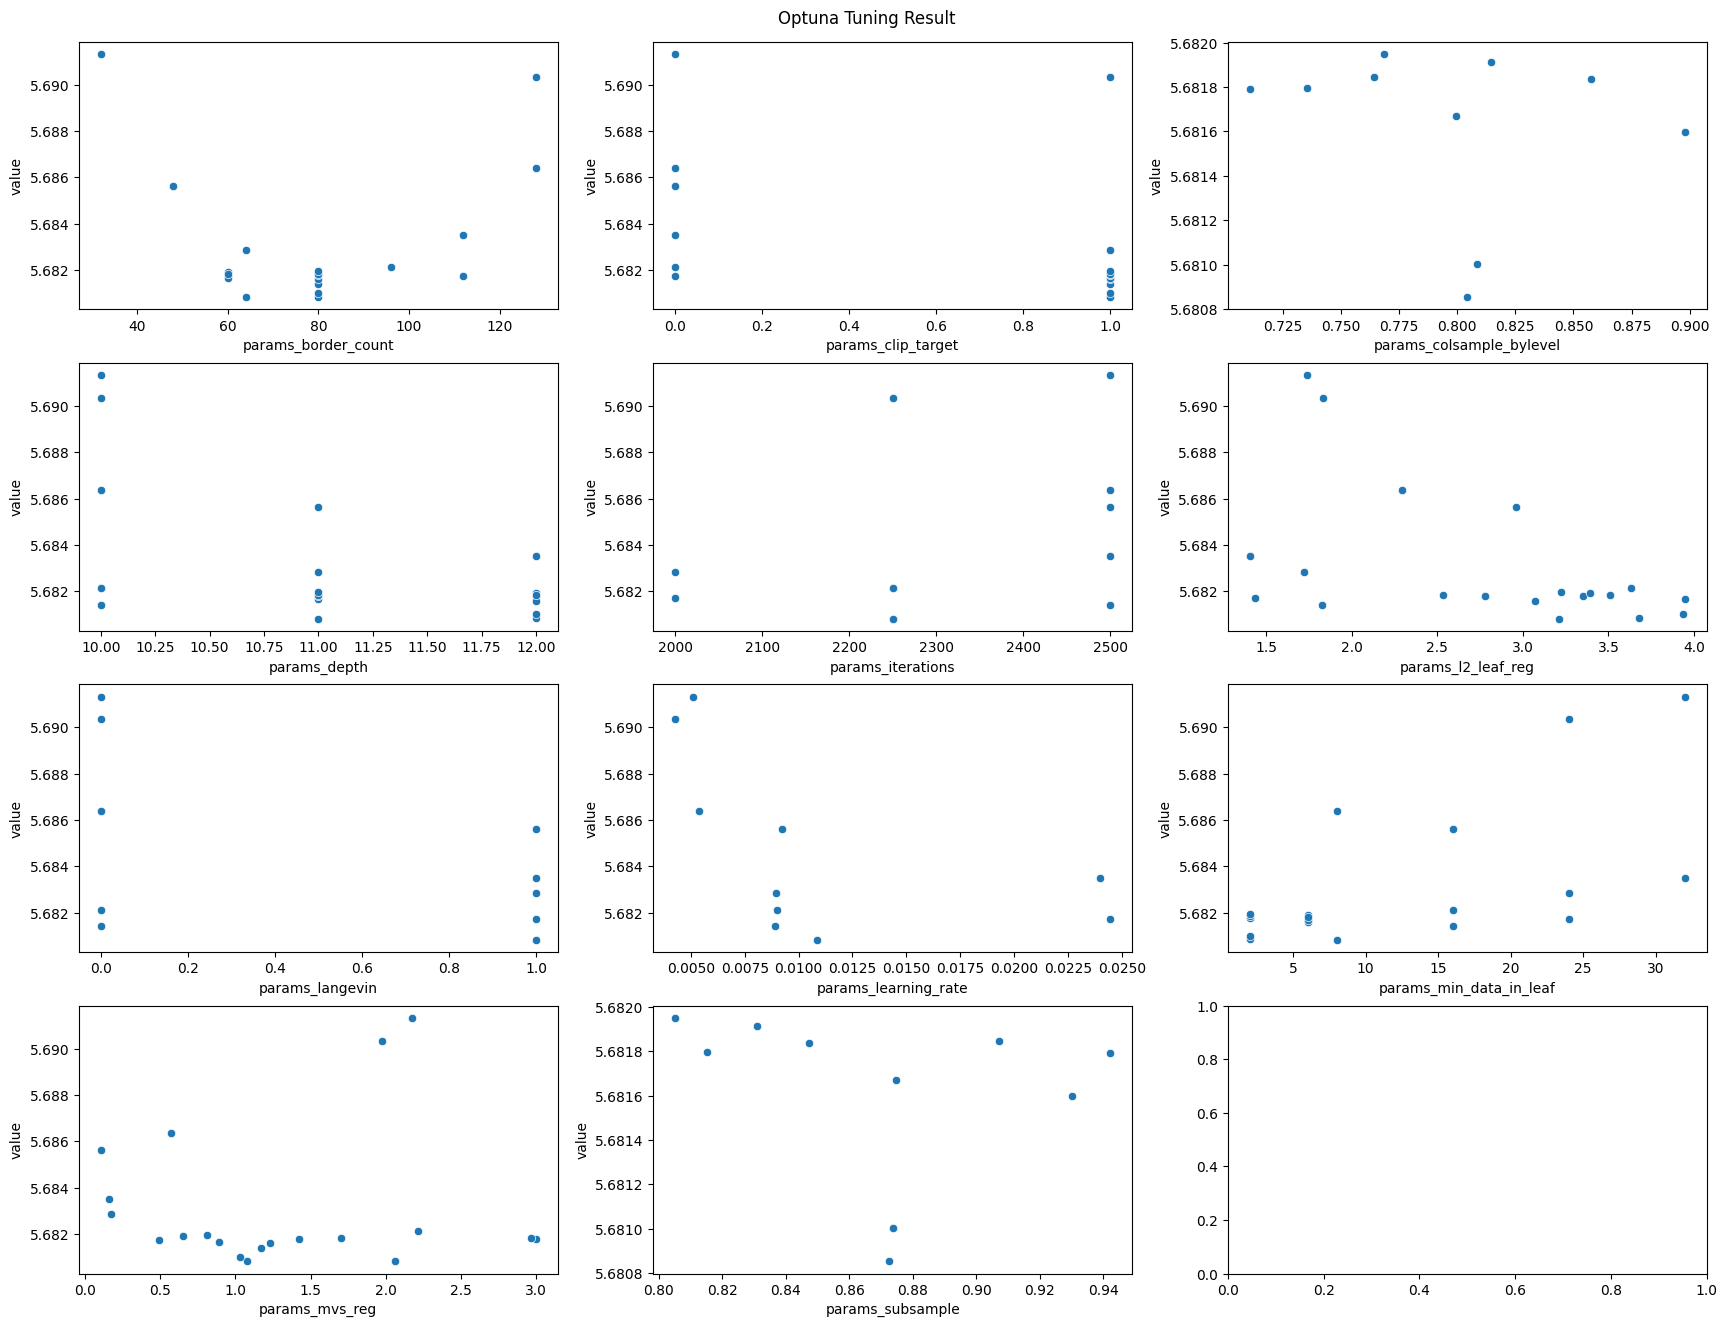

In [39]:
study_df = study2.trials_dataframe()
study_df = study_df.loc[study_df["state"] == "COMPLETE"]
# study_df.to_csv(f"../optuna_trials.csv", index=False)
fig, ax = plt.subplots(4, 3, figsize=(21, 16))
ax = ax.ravel()
for i, col in enumerate(get_cols(study_df, "params")):
    sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"], ax=ax[i])
plt.suptitle("Optuna Tuning Result", y=0.9)
plt.savefig("../tuning_result/cat_optuna_result2.png")
plt.show()

### Train for Validation

In [87]:
# prev_catboost_val_model = read_model(f"{DATA_DIR}/optiver-catboost-models/cat_model1_val.cbm")
# prev_catboost_val_model

In [88]:
# These are be the static hyperparams for our ML problem + your machine specifications
cat_general_settings = dict(
    loss_function='MAE', 
    random_state=923,
    task_type="CPU", 
    verbose=1
)

In [89]:
# We manually set here, but this can be str8 away came from optuna best hyper-params
cat_params = {
    'iterations': 1200,
    'learning_rate': 0.05,
    'depth': 11,
    'subsample': 0.88,
    'colsample_bylevel': 0.85,
    'min_data_in_leaf': 12,
    'l2_leaf_reg': 3.98,
    'border_count': 150,
    'mvs_reg': 2.645,
    'sampling_frequency': 'PerTreeLevel',
    'langevin': True,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'MVS',
    'use_best_model': True, 
    'od_type': "Iter",
    'od_wait': 100,
    'metric_period': 25,
}

In [90]:
# Final hyper-params set
full_cat_params = cat_general_settings | cat_params
print(full_cat_params)

{'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 1200, 'learning_rate': 0.05, 'depth': 11, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.98, 'border_count': 150, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 100, 'metric_period': 25}


In [91]:
len(feature_list)

442

In [92]:
%%time
tr = filter_df(train, date_id=(0, 420), seconds=(0, 540)).reset_index(drop=True)
va = filter_df(train, date_id=(421, 480), seconds=(0, 540)).reset_index(drop=True)

X_tr = tr.loc[:, feature_list]
y_tr = tr["clipped_target"]
X_va = va.loc[:, feature_list]
y_va = va["target"]

CPU times: user 2.4 s, sys: 14.8 s, total: 17.2 s
Wall time: 53.4 s


In [93]:
del tr, va
gc.collect()

144

In [94]:
# X_tr = X_tr.dropna(how="all", axis=1)
# X_va = X_va.dropna(how="all", axis=1)

In [95]:
%%time
cprint(f"{get_time_now()}, Hyperparams: {full_cat_params}", color="green")
val_model = CatBoostRegressor(**full_cat_params)
val_model.fit(
    X_tr, 
    y_tr,
    eval_set=Pool(X_va, y_va)
)

15:14:23, Hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 1200, 'learning_rate': 0.05, 'depth': 11, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.98, 'border_count': 150, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 100, 'metric_period': 25}


0:	learn: 6.4765807	test: 5.8079807	best: 5.8079807 (0)	total: 4.25s	remaining: 1h 25m 2s
25:	learn: 6.3627594	test: 5.7306554	best: 5.7306554 (25)	total: 1m 46s	remaining: 1h 20m 4s
50:	learn: 6.3322990	test: 5.7141279	best: 5.7141279 (50)	total: 3m 32s	remaining: 1h 19m 41s
75:	learn: 6.3134216	test: 5.7056219	best: 5.7056219 (75)	total: 5m 25s	remaining: 1h 20m 11s
100:	learn: 6.2988291	test: 5.6995209	best: 5.6995209 (100)	total: 7m 25s	remaining: 1h 20m 50s
125:	learn: 6.2858233	test: 5.6965501	best: 5.6965501 (125)	total: 9m 38s	remaining: 1h 22m 13s
150:	learn: 6.2737545	test: 5.6937213	best: 5.6937213 (150)	total: 11m 47s	remaining: 1h 21m 53s
175:	learn: 6.2629294	test: 5.6915993	best: 5.6915946 (174)	total: 13m 49s	remaining: 1h 20m 26s
200:	learn: 6.2525175	test: 5.6905062	best: 5.6905062 (200)	total: 15m 50s	remaining: 1h 18m 42s
225:	learn: 6.2418771	test: 5.6890564	best: 5.6890564 (225)	total: 17m 54s	remaining: 1h 17m 12s
250:	learn: 6.2320629	test: 5.6885416	best: 5.688

In [113]:
model.save_model(cat_val_model_path)

### Remove correlated features and retrain

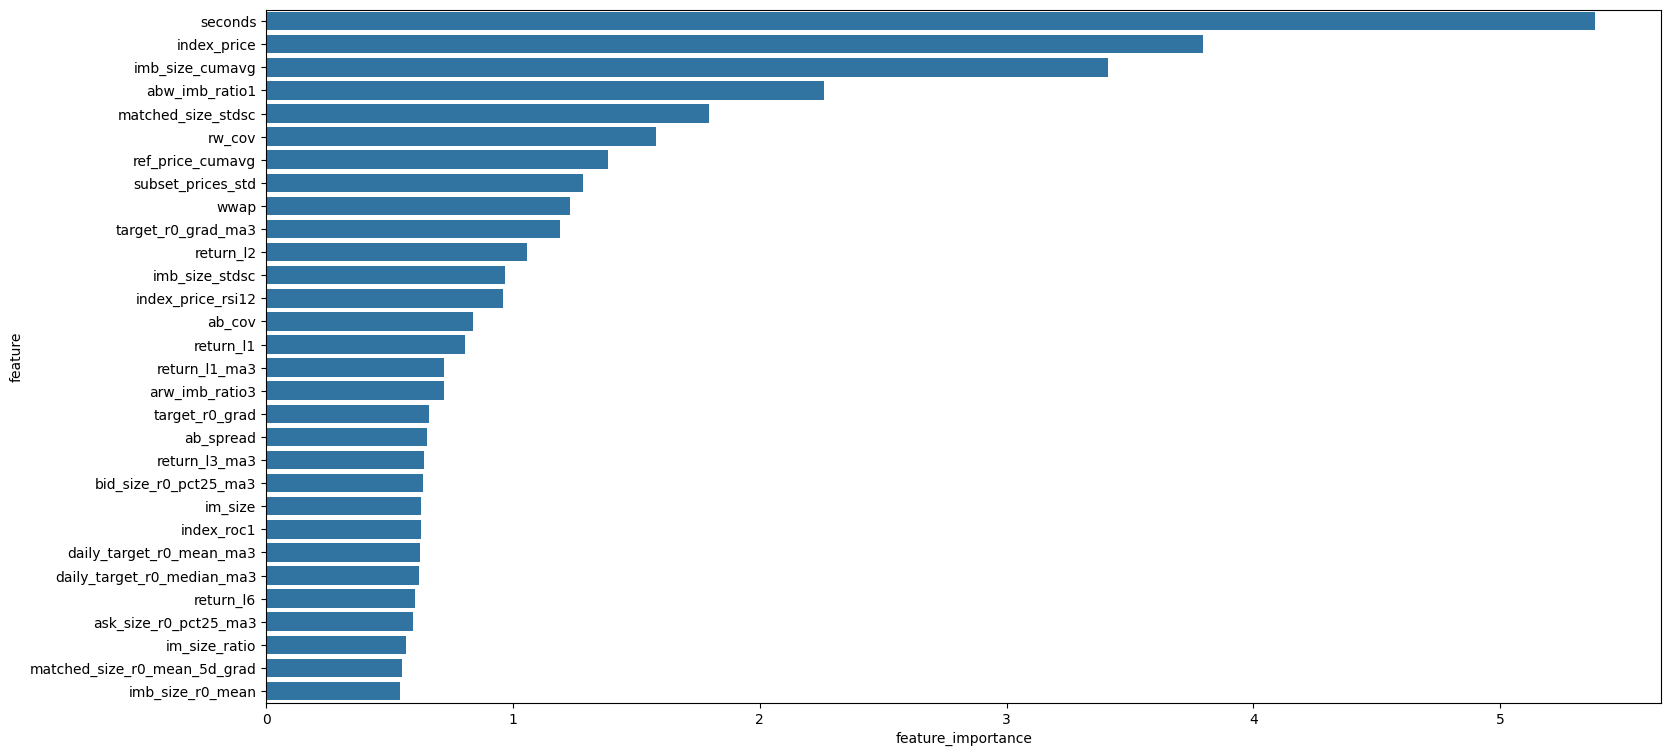

In [114]:
cat_imp_df = plot_feature_importance(model.feature_names_, model.get_feature_importance(), return_df=True, limit=30, figsize=(18, 9))

In [100]:
low_imp_features = cat_imp_df.loc[cat_imp_df["feature_importance_rank"] >= 380, "feature"].tolist()
len(low_imp_features)

63

In [108]:
# corr_df = read_data("../corr_df.parquet")

In [101]:
corr_df = corr_df.loc[cat_imp_df.feature.tolist(), cat_imp_df.feature.tolist()]

In [106]:
linkage_matrix = sch.linkage(corr_df.fillna(0).values, method='ward', metric='euclidean')
clusters = fcluster(linkage_matrix, 0.01, criterion='distance')
feature_cluster_df = pd.DataFrame(dict(feature=corr_df.columns.tolist(), clusters=clusters))
best_features = feature_cluster_df.groupby("clusters")["feature"].apply(list).progress_apply(lambda x: cat_imp_df.loc[cat_imp_df["feature"].isin(x), "feature"].iloc[0]).tolist()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:00<00:00, 8561.23it/s]


In [107]:
best_features = list_diff(best_features, low_imp_features)
len(best_features)

362

In [109]:
%%time
tr = filter_df(train, date_id=(0, 420), seconds=(0, 540)).reset_index(drop=True)
va = filter_df(train, date_id=(421, 480), seconds=(0, 540)).reset_index(drop=True)

X_tr = tr.loc[:, best_features]
y_tr = tr["clipped_target"]
X_va = va.loc[:, best_features]
y_va = va["target"]

CPU times: user 2.33 s, sys: 14.7 s, total: 17.1 s
Wall time: 1min 4s


In [110]:
del tr
gc.collect()

736

In [111]:
%%time
cprint(f"{get_time_now()}, Hyperparams: {full_cat_params}", color="green")
model = CatBoostRegressor(**full_cat_params)
model.fit(
    X_tr, 
    y_tr,
    eval_set=Pool(X_va, y_va)
)

16:22:34, Hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 1200, 'learning_rate': 0.05, 'depth': 11, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.98, 'border_count': 150, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': True, 'od_type': 'Iter', 'od_wait': 100, 'metric_period': 25}


0:	learn: 6.4754545	test: 5.8075804	best: 5.8075804 (0)	total: 4.07s	remaining: 1h 21m 21s
25:	learn: 6.3626365	test: 5.7302467	best: 5.7302467 (25)	total: 1m 31s	remaining: 1h 9m 13s
50:	learn: 6.3327436	test: 5.7130333	best: 5.7130333 (50)	total: 3m 1s	remaining: 1h 8m 17s
75:	learn: 6.3145949	test: 5.7055247	best: 5.7055247 (75)	total: 4m 35s	remaining: 1h 7m 55s
100:	learn: 6.3000416	test: 5.6999967	best: 5.6999967 (100)	total: 6m 12s	remaining: 1h 7m 34s
125:	learn: 6.2866400	test: 5.6959356	best: 5.6959356 (125)	total: 7m 52s	remaining: 1h 7m 6s
150:	learn: 6.2740121	test: 5.6934035	best: 5.6934035 (150)	total: 9m 36s	remaining: 1h 6m 41s
175:	learn: 6.2619408	test: 5.6914929	best: 5.6914929 (175)	total: 11m 18s	remaining: 1h 5m 49s
200:	learn: 6.2499609	test: 5.6895784	best: 5.6895784 (200)	total: 13m 25s	remaining: 1h 6m 42s
225:	learn: 6.2400244	test: 5.6888472	best: 5.6888472 (225)	total: 15m 33s	remaining: 1h 7m 1s
250:	learn: 6.2294973	test: 5.6879872	best: 5.6879872 (250)	

In [115]:
cprint(f"{get_time_now()}, Done Training, Predicting Now...", color="green")
va["cat_pred"] = model.predict(X_va)
mae = (va["cat_pred"] - y_va).abs().mean()
print(mae)

17:11:13, Done Training, Predicting Now...
5.683970710490443


In [116]:
model.save_model(val_model_path)

In [117]:
va = va[META_COLUMNS + ["target", "cat_pred"]]
va.to_csv(val_data_path, index=False)

### Train for Submission (Final Model)

In [118]:
# Can update the number of trees if the early stopping get hit during validation, because we have no holdout set for early stopping when we train using Date ID 1 - 480
best_cat_params = full_cat_params
best_cat_params["iterations"] = int(model.best_iteration_ * 1.1)
best_cat_params["use_best_model"] = False
best_cat_params

{'loss_function': 'MAE',
 'random_state': 923,
 'task_type': 'CPU',
 'verbose': 1,
 'iterations': 603,
 'learning_rate': 0.05,
 'depth': 11,
 'subsample': 0.88,
 'colsample_bylevel': 0.85,
 'min_data_in_leaf': 12,
 'l2_leaf_reg': 3.98,
 'border_count': 150,
 'mvs_reg': 2.645,
 'sampling_frequency': 'PerTreeLevel',
 'langevin': True,
 'grow_policy': 'SymmetricTree',
 'bootstrap_type': 'MVS',
 'use_best_model': False,
 'od_type': 'Iter',
 'od_wait': 100,
 'metric_period': 25}

In [122]:
%%time
tr = filter_df(train, date_id=(1, 480)).reset_index(drop=True)
va = filter_df(train, date_id=(478, 480)).reset_index(drop=True)

CPU times: user 1.83 s, sys: 10.5 s, total: 12.3 s
Wall time: 48.5 s


In [123]:
%%time
X_tr = tr.loc[:, best_features]
y_tr = tr["clipped_target"]
X_va = va.loc[:, best_features]
y_va = va["target"]

CPU times: user 342 ms, sys: 2.85 s, total: 3.19 s
Wall time: 10.1 s


In [130]:
check_memory_usage()

RAM used: 2.2 GB


2.1542510986328125

In [131]:
%%time
cprint(f"{get_time_now()}, Best Hyperparams: {best_cat_params}", color="green")
final_model = CatBoostRegressor(**best_cat_params)
final_model.fit(
    X_tr, 
    y_tr
)

02:37:02, Best Hyperparams: {'loss_function': 'MAE', 'random_state': 923, 'task_type': 'CPU', 'verbose': 1, 'iterations': 865, 'learning_rate': 0.04, 'depth': 10, 'subsample': 0.88, 'colsample_bylevel': 0.85, 'min_data_in_leaf': 18, 'l2_leaf_reg': 4.045, 'border_count': 128, 'mvs_reg': 2.645, 'sampling_frequency': 'PerTreeLevel', 'langevin': True, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'MVS', 'use_best_model': False, 'od_type': 'Iter', 'od_wait': 90, 'metric_period': 25}
0:	learn: 6.3945289	total: 3.59s	remaining: 51m 41s
25:	learn: 6.2988232	total: 1m 32s	remaining: 49m 58s
50:	learn: 6.2727067	total: 3m	remaining: 48m
75:	learn: 6.2584969	total: 4m 34s	remaining: 47m 29s
100:	learn: 6.2477157	total: 6m 12s	remaining: 46m 57s
125:	learn: 6.2392394	total: 7m 58s	remaining: 46m 43s
150:	learn: 6.2316978	total: 9m 45s	remaining: 46m 7s
175:	learn: 6.2243617	total: 11m 35s	remaining: 45m 21s
200:	learn: 6.2180567	total: 13m 22s	remaining: 44m 11s
225:	learn: 6.2121231	total: 15

In [132]:
final_model.save_model(final_model_path)

## Try R1 R2 Models

In [35]:
train_r1 = filter_df(train, seconds=(0, 290), reset_index=True)
train_r2 = filter_df(train, seconds=(300, 540), reset_index=True)
train_r1 = train_r1.dropna(how="all", axis=1)
assert (train_r1.shape[0] + train_r2.shape[0]) == train.shape[0], "Not Tally"

r1_features = get_final_features(train_r1, corr_but_noob_features, target_columns=target_column_list)
r2_features = get_final_features(train_r2, corr_but_noob_features, target_columns=target_column_list)
len(r1_features), len(r2_features)

(271, 320)

In [38]:
%%time
val_model_r2, valid_pred_r2, best_score = train_lgbm(
    data=train_r2, train_start_date=0, train_end_date=420, val_start_date=421, 
    es=True, get_val_pred=True, feature_list=r2_features, lgbm_params=final_lgbm_params
)

11:26:37 Preparing Dataset...
11:26:44 Training...
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 5.65184	training's mae: 5.65184	valid_0's l1: 4.9485	valid_0's mae: 4.9485
[200]	training's l1: 5.54782	training's mae: 5.54782	valid_0's l1: 4.93295	valid_0's mae: 4.93295
[300]	training's l1: 5.46663	training's mae: 5.46663	valid_0's l1: 4.92811	valid_0's mae: 4.92811
[400]	training's l1: 5.39743	training's mae: 5.39743	valid_0's l1: 4.92629	valid_0's mae: 4.92629
[500]	training's l1: 5.33653	training's mae: 5.33653	valid_0's l1: 4.92631	valid_0's mae: 4.92631
Early stopping, best iteration is:
[448]	training's l1: 5.36747	training's mae: 5.36747	valid_0's l1: 4.92575	valid_0's mae: 4.92575
Evaluated only: l1
11:35:00 Getting Validation Prediction...
CPU times: user 52min 45s, sys: 10min 45s, total: 1h 3min 31s
Wall time: 8min 26s


In [ ]:
final_val = pd.concat([valid_pred_r1, valid_pred_r2], ignore_index=True)
final_val = final_val.merge(train[META_COLUMNS + ["target"]], on=META_COLUMNS, how="left")
final_val = final_val.merge(va[META_COLUMNS + ["lgbm_v7_pred"]], on=META_COLUMNS, how="left")
final_val["avg"] = (final_val["lgbm_v7_pred"] + final_val["val_pred"]) / 2

# Feature Analysis

In [13]:
all_logp = pd.read_csv("../features_summary/features_logp_values.csv")
all_logp.head()

,stock_id,date_id,seconds,ab_gap,ab_gap_ar_gap_fod_ratio,ab_gap_ar_gap_fod_spread,ab_gap_ar_gap_fod_sum,ab_gap_aw_gap_fod_ratio,ab_gap_aw_gap_fod_spread,ab_gap_aw_gap_fod_sum,...,abm_imb_ratio3,price_pressure,market_urgency,wwap,abm_imb_ratio1,bim_imb_ratio3,bw_depth_pressure,am_st_ratio,weight,ab_st_ratio
0,0,-461.57883,-389.206270,-187.82472,-25.712883,-70.565020,-71.720665,-7.982771,-31.442432,-39.312466,...,-15.109345,-199.10718,-105.01898,-41.105220,-15.693370,-69.164055,-9.284789,-38.769245,0.0,-8.999992
1,1,-255.99847,-50.908030,-95.85843,-1.970455,-31.303220,-18.432371,-7.302582,-58.321200,-107.524920,...,-2.285080,-34.22804,-745.00000,-56.152970,-2.340367,-55.779106,-373.447080,-140.826050,0.0,-483.384340
2,2,-285.27423,-60.181583,-226.42468,-1.753751,-57.731570,-32.764600,-15.509977,-67.374170,-194.751070,...,-5.372412,-132.27824,-745.00000,-69.289580,-5.385533,-54.519524,-422.289370,-184.418170,0.0,-438.427280
3,3,-476.75760,-417.776340,-167.16582,-8.670104,-68.847800,-52.333294,-3.675680,-40.057570,-42.837223,...,-7.751771,-196.29108,-151.11436,-26.448440,-7.775989,-69.673400,-27.209745,-26.891043,0.0,-30.637623
4,4,-296.97943,-285.855220,-128.71718,-23.655752,-33.396355,-18.730232,-4.442601,-29.449490,-52.478240,...,-5.359083,-91.10555,-223.43639,-33.808147,-5.362135,-45.823254,-83.076580,-33.435528,0.0,-95.377370


In [16]:
all_logp = all_logp.set_index("stock_id")

In [28]:
all_logp_agg = 0.5 * all_logp.median() + 0.25 * (all_logp.apply(percentile(0.75)) + all_logp.apply(percentile(0.25)))

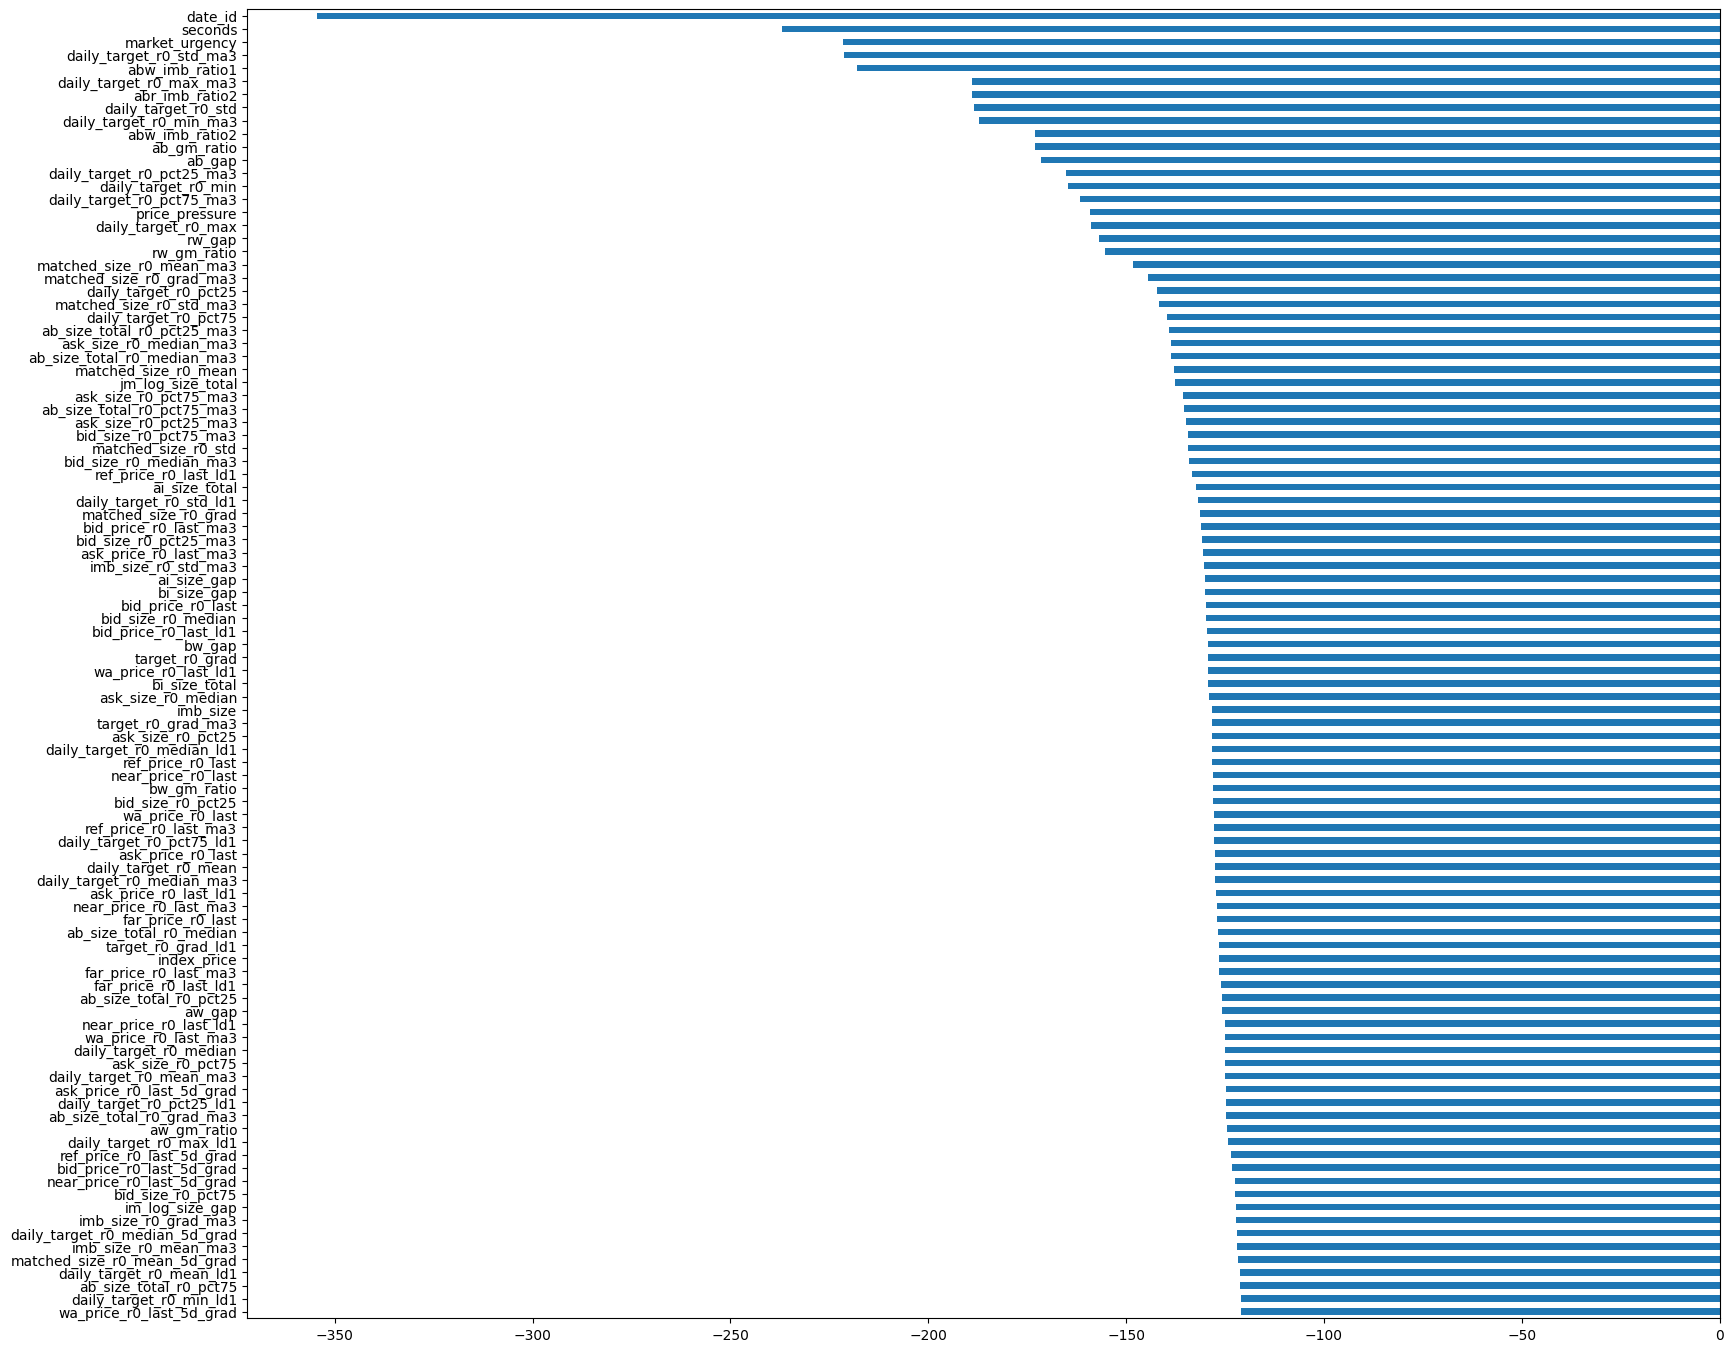

In [38]:
plt.figure(figsize=(19, 17))
all_logp_agg.sort_values()[:100][::-1].plot.barh()
plt.show()

# Error Analysis

# Test Simple Averaging Ensemble

In [127]:
cat_val_data_path

'../data//optiver-catboost-models/cat_model3_val.csv'

In [128]:
lgbm_val_data_path

'../data//optiver-lgbm-models/lgbm_model9_val.csv'

In [178]:
get_cols(train, "rbtsc")

['bid_size_rbtsc', 'ask_size_rbtsc']

In [179]:
cat = read_data(cat_val_data_path)
lgbm = read_data(lgbm_val_data_path)
lgbm["cat_pred"] = cat["cat_pred"]
lgbm["final_pred"] = (.5 * lgbm["cat_pred"] + .5 * lgbm["val_pred"])
lgbm = lgbm.merge(train[META_COLUMNS + ["bid_size", "ask_size", "matched_size", "ab_size_gap", "ask_size_rbtsc", "bid_size_rbtsc"]], on=META_COLUMNS, how="left")
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm['bid_size'] + lgbm['ask_size']
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.678987665792115

In [180]:
c1 = read_data("../data/optiver-catboost-models/cat_model2_val.csv")
l1 = read_data("../data/optiver-lgbm-models/lgbm_model8_val.csv")

In [181]:
lgbm["cat_pred1"] = c1["cat_pred"]
lgbm["val_pred1"] = l1["val_pred"]

In [182]:
lgbm["final_pred"] = 0.25 * (lgbm["cat_pred1"] + lgbm["cat_pred"] + lgbm["val_pred"] + lgbm["val_pred1"])
(lgbm["final_pred"] - lgbm["target"]).abs().mean()

5.677299856265766

In [192]:
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm["ask_size"] * np.abs(my_log(lgbm["ask_size_rbtsc"])) + lgbm["bid_size"] * np.abs(my_log(lgbm["bid_size_rbtsc"]))
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.677356032170784

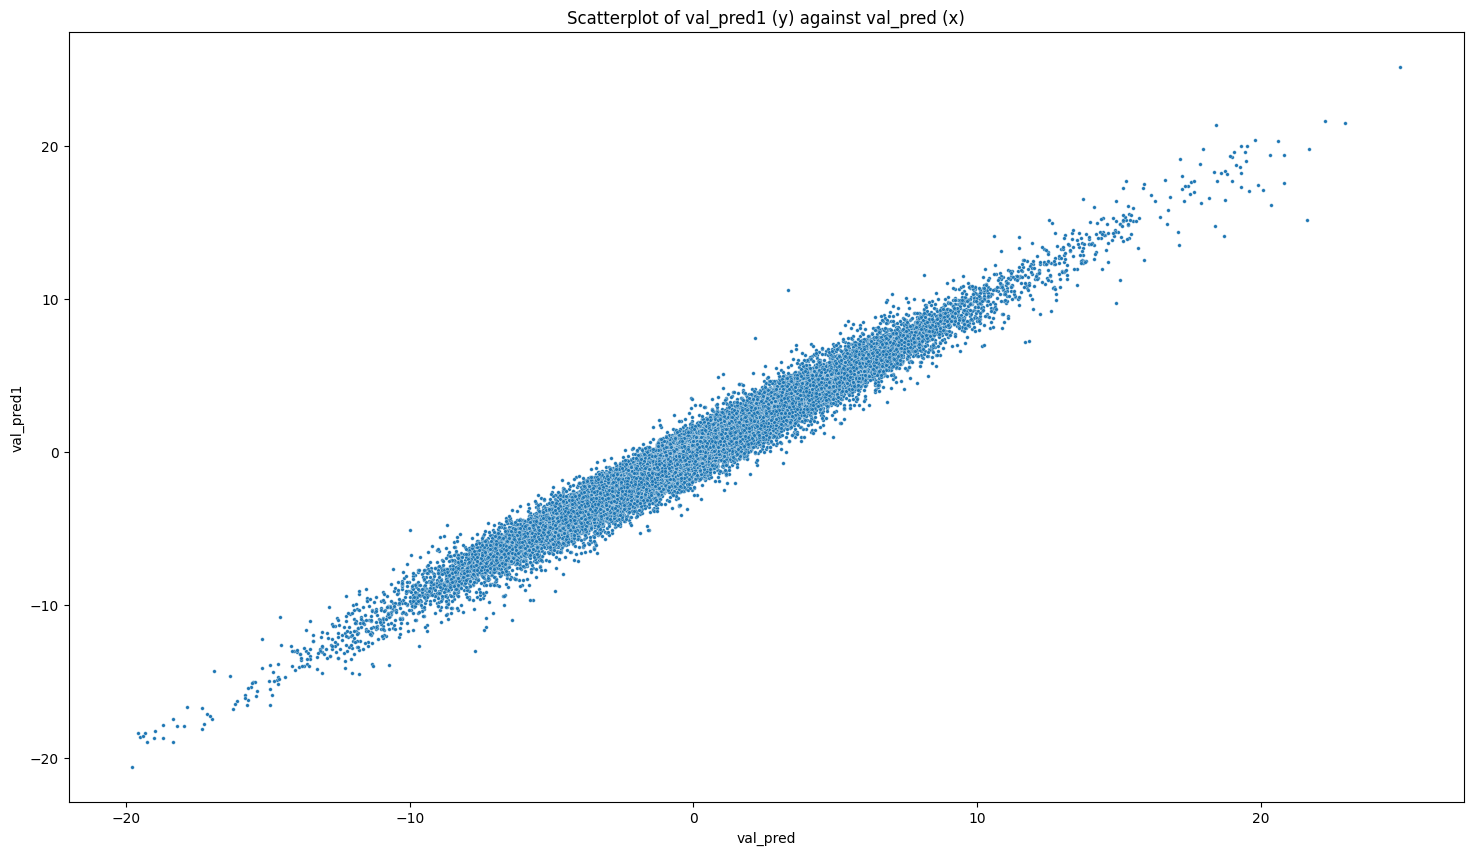

In [136]:
plot_scatterplot(lgbm, x_col="val_pred", y_col="val_pred1")

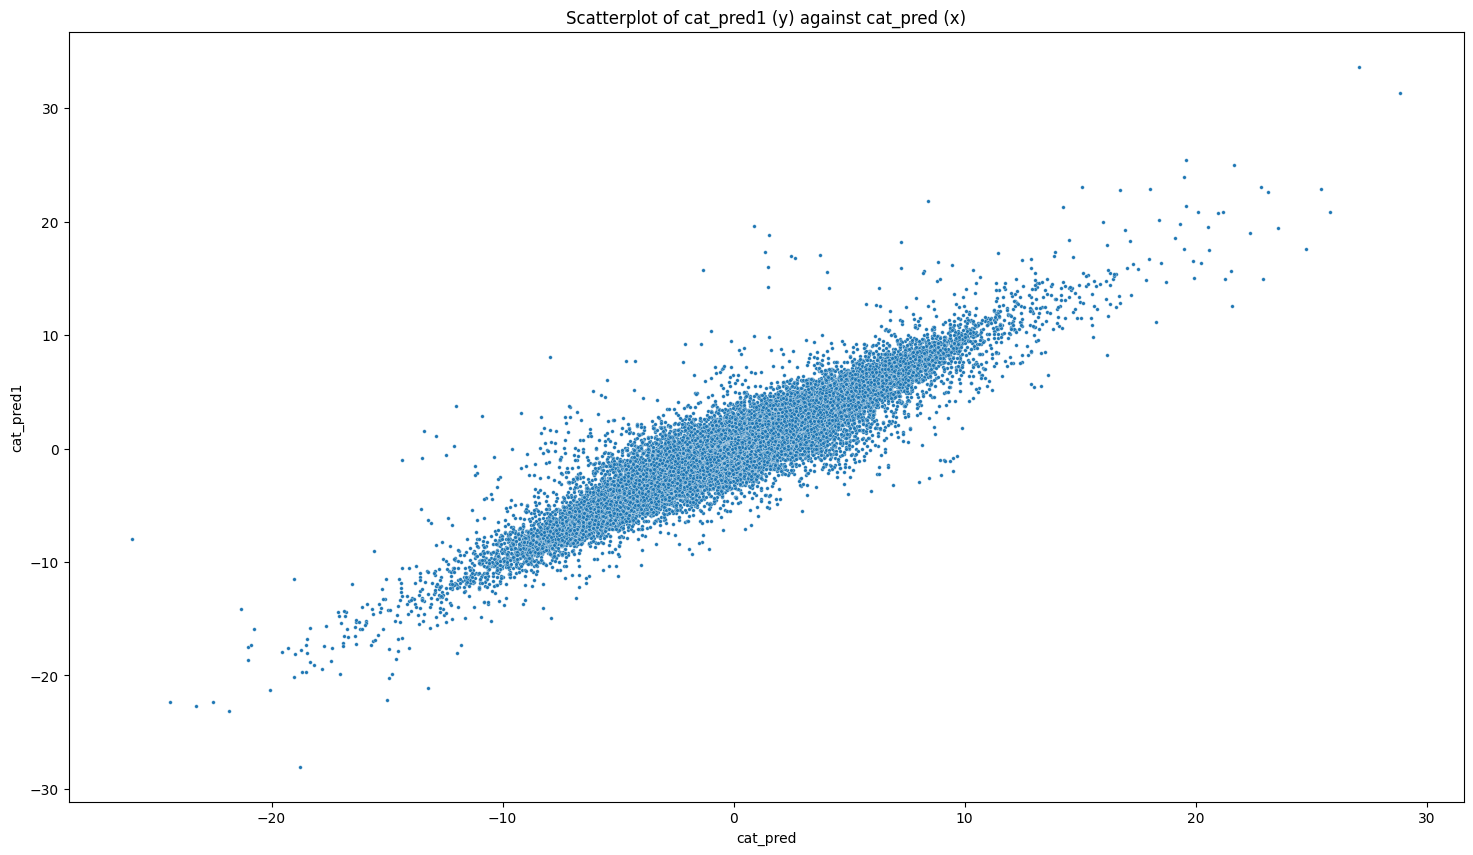

In [135]:
plot_scatterplot(lgbm, x_col="cat_pred", y_col="cat_pred1")

# Try Stack Logistic Regression

In [198]:
lgbm[["cat_pred", "cat_pred1", "val_pred1", "val_pred", "target"]]

,cat_pred,cat_pred1,val_pred1,val_pred,target
0,-0.830997,-0.929836,-1.309504,-1.578251,2.779961
1,-0.810464,-0.884285,-0.726944,-0.964731,4.869700
2,-0.455012,-0.822082,-0.414411,-0.425402,6.250143
3,-0.093208,-0.452160,-0.194242,-0.213853,7.139444
4,0.487792,0.267143,0.533044,0.673420,8.139610
...,...,...,...,...,...
659940,-2.392395,-2.044426,-1.982899,-1.841747,-7.209778
659941,-1.628953,-1.010354,-0.575198,-0.811155,-9.750128
659942,1.252752,0.996103,1.173841,0.984923,3.629923
659943,0.750795,0.261070,0.397068,0.681712,4.760027


In [233]:
final_df = lgbm.merge(train.loc[:, META_COLUMNS + get_cols(train, ["flag", "signal", "bollinger"]) + ["clipped_target"]], on=META_COLUMNS, how="left")

In [234]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GroupKFold

In [235]:
features = ["cat_pred", "cat_pred1", "val_pred1", "val_pred"] + get_cols(train, ["flag", "signal", "bollinger"])

In [236]:
for col in final_df.columns:
    final_df[col] = final_df[col].fillna(final_df[col].mean())

In [237]:
group_kfold = GroupKFold()

In [257]:
%%time
val_pred_list, val_gt_list = [], []
for tr_index, val_index in tqdm(group_kfold.split(final_df, final_df["target"], groups=final_df["stock_id"])):
    X_val = final_df.loc[val_index, features]
    X_train = final_df.loc[tr_index, features]
    y_val = final_df.loc[val_index, "target"]
    y_train = final_df.loc[tr_index, "clipped_target"]
    
    # r = Ridge()
    cb = CatBoostRegressor(verbose=0)
    cb.fit(X_train, y_train)
    val_pred_list.extend(list(cb.predict(X_val)))
    val_gt_list.extend(y_val.tolist())

5it [01:15, 15.11s/it]

CPU times: user 7min 25s, sys: 24.1 s, total: 7min 49s
Wall time: 1min 15s


In [258]:
pd.Series(np.array(val_pred_list) - np.array(val_gt_list)).abs().mean()

5.705074519898685

5.678458627763317